# Hubs and authorities


In this session we will compute Hubs and Authorities using [NetworkX](https://networkx.github.io/), a Python package. This analysis is inspired by a paper on international trade ([Deguchi et al. 2014](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0100338)).

The dataset we will use comes from OECD's [trade in value by partner country](https://stats.oecd.org/Index.aspx?DataSetCode=PARTNER) dataset, and these are your input files:

* ``trade_1980-flows.csv`` international trade in 1980
* ``trade_2013-flows.csv`` international trade in 2013
* ``trade_2013-countries.csv`` list of countries and territories

Plese note that the [HITS](https://en.wikipedia.org/wiki/HITS_algorithm) or hubs and authorities algorithm is implemented in NetworkX and elsewhere, but the other implementations follow a different design. Do this assignment on your own, following the design in this Notebook.

# 0. Code snippets needed

## 0.1. Reading a compressed CSV file

```python
# Open a compressed file for reading in text mode
with gzip.open(FILENAME, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')
    
    # Iterate through records, each record is a dictionary
    for record in reader:
        print(record)
```

## 0.2. Creating a directed graph in NetworkX

Create an empty graph using:

```python
g = nx.DiGraph()
```

Then read the file and add weighted edges to `g`. To add a weighted edge from node *u* to node *v* with weight *w*, use `g.add_edge(u, v, weight=w)`.


## 0.3. Iterate through a graph in NetworkX

To iterate through the nodes of a graph:

```python
for n in g.nodes():
    # n is the name of the node
```

To iterate through the edges of a graph:

```python
for u, v, d in g.edges(data=True):
    w = d['weight']
    # u is the source, v the destination, w the weight
```

## 0.4. Create an empty dictionary from a set

Suppose you want to create dictionary `d` initialized so that all keys are the elements of set `s` and all values are zero:

```python
d = dict([(element,0) for element in s])
```


# 1. Read mapping of codes to country names

Read into variable ``id2name`` the file containing the list of countries and territories.

In [1]:
import csv
import gzip
import io
import networkx as nx
import matplotlib.pyplot as plt
import math
import pandas as pd

In [2]:
INPUT_NAMES_FILENAME = "trade-countries.csv.gz"
INPUT_TRADE_1980 = "trade_1980-flows.csv.gz"
INPUT_TRADE_2013 = "trade_2013-flows.csv.gz"

# Organisation for Economic Co-operation and Development
OECD = set(["AUS", "AUT", "BEL", "CAN", "CHL", "COL", "CZE", "DNK", "EST", "FIN", "FRA",
        "DEU", "GRC", "HUN", "ISL", "IRL", "ISR", "ITA", "JPN", "KOR", "LVA", "LTU",
        "LUX", "MEX", "NLD", "NOR", "NZL", "POL", "CHE", "ESP", "GBR", "PRT", "SVK",
        "SVN", "SWE", "TUR", "USA"])

# Brazil, Russia, India and China
BRIC = set(["BRA", "RUS", "IND", "CHN"])

# COUNTRIES
COUNTRIES = OECD.union(BRIC)

In [3]:
id2name_all = {} #The short name for every country in the file is saved
id2name_country={}#Complete name for every country in COUNTRIES is saved.

# Open a compressed file for reading in text mode
with gzip.open(INPUT_NAMES_FILENAME, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    index_all=0
    index_country=0
    for record in reader:
        id2name_all[index_all]=record["code"]
        index_all+=1
    
        if(record["code"] in COUNTRIES):
            id2name_country[index_country]=record["name"]
            index_country+=1

# 2. Read flows data into two graphs

Read the graphs as directed graphs into variables `g_old` (1980 data) and `g_new` (2013 data).

In some rows the `amount` is empty. Hence, you will have to consider those as zeroes. You can do, for instance: `amount = float(record["amount"]) if len(record["amount"]) > 0 else 0.0`. Divide the amounts by one million and round to the nearest integer, so the weights will be expressed in millions of dollars.

Add only the edges that describe a trade amount that is non-zero (i.e., more than half a million dollars), and that involve OECD or BRIC countries; we do not care if the country is OECD or BRIC, but the country must belong to one of those groups to be included in the graph.

Notice the column "Import":

* If the flow is "Import", add an edge *from country2 to country1*.
* If the flow is "Export", add an edge *from country1 to country2*.

Now, the problem is that in most cases the data has some inconsistencies, for instance:

```
Import,USA,ITA,USD,3221525000
Export,ITA,USA,USD,2992289762
```

These numbers are different because they are reported by different countries, probably using different accounting methods. The best solution is to take the average of both numbers.

For that, you can use `g.has_edge(source, dest)` to check if an edge already exists, `g.get_edge_data(source, dest, key='weight')` to obtain the label "weight" of an existing edge, `g.remove_edge(source, dest)` to remove the edge, and `g.add_edge(source, dest, weight=x)` to add an edge from *source* to *dest* with weight *x*.

You can assume each edge appears at most twice, or keep two labels per edge: *sum* and *count*, and then create a new label with the *sum/count* for every edge after reading the graph.


In [4]:
g1980 = nx.DiGraph()
for u in COUNTRIES: #it creates an empty graph with all the nodes 
        g1980.add_node(u)
        
 
              
# Open a compressed file for reading in text mode
with gzip.open(INPUT_TRADE_1980, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    
    for record in reader:
        flow=record["flow"]
        country1=record["country1"]
        country2=record["country2"]
        if (len(record["amount"]) > 0):  #computes the weight of the edges
            w = float(record["amount"])
            w= round(w/1000000)
        else:
            w=0.0  
        if(country1 in COUNTRIES and country2 in COUNTRIES and w>0):#checks if it is an Import or export and adds the proper edge
            if(flow=="Import"):
                if(g1980.has_edge(country2,country1)):#checks if it is a repetead edge and adds the new one with average
                    old_w=g1980.get_edge_data(country2,country1,"weight")
                    new_w=round((old_w["weight"]+w)/2)
                    g1980.remove_edge(country2,country1)
                    g1980.add_edge(country2,country1,weight=new_w)
                    
                else:#if it is not repeated, just add the new node
                    g1980.add_edge(country2, country1, weight=w)
                
            else:
                if(g1980.has_edge(country1,country2)):#checks if it is a repetead edge and adds the new one with average
                    old_w=g1980.get_edge_data(country1,country2,"weight")
                    new_w=round((old_w["weight"]+w)/2)
                    g1980.remove_edge(country1,country2)
                    g1980.add_edge(country1,country2,weight=new_w)
                    
                else:#if it is not repeated, just add the new node
                    g1980.add_edge(country1, country2, weight=w)

    input_file.close()
                    

        
        



g2013 = nx.DiGraph()
for u in COUNTRIES: #2.it iterates N times, creating N nodes from 0 to N-  
        g2013.add_node(u)
 
              
# Open a compressed file for reading in text mode
with gzip.open(INPUT_TRADE_2013, "rt") as input_file:

    # Create a CSV reader for a comma-delimited file with a header
    reader = csv.DictReader(input_file, delimiter=',')

    # Iterate through records, each record is a dictionary
    
    for record in reader:
        flow=record["flow"]
        country1=record["country1"]
        country2=record["country2"]
        if (len(record["amount"]) > 0): #computes the weight of the edges
            w = float(record["amount"])
            w= round(w/1000000)
        else:
            w=0.0  
        if(country1 in COUNTRIES and country2 in COUNTRIES ):#checks if is an Import or export and adds the proper edge
            if(flow=="Import"):
                if(g2013.has_edge(country2,country1)):#checks if it is a repetead edge and adds the new one with average
                    old_w=g2013.get_edge_data(country2,country1,"weight")
                    new_w=round((old_w["weight"]+w)/2)
                    g2013.remove_edge(country2,country1)
                    g2013.add_edge(country2,country1,weight=new_w)
                else:#if it is not repeated, just add the new node
                    g2013.add_edge(country2, country1, weight=w)
            else:#it is an export
                if(g2013.has_edge(country1,country2)):#checks if it is a repetead edge and adds the new one with average
                    old_w=g2013.get_edge_data(country1,country2,"weight")
                    new_w=round((old_w["weight"]+w)/2)
                    g2013.remove_edge(country1,country2)
                    g2013.add_edge(country1,country2,weight=new_w)
                else:#if it is not repeated, just add the new node
                    g2013.add_edge(country1, country2, weight=w)

    input_file.close()                  
                
         

Draw the two graphs using NetworkX. Define an auxiliary function named `plotGraph` for this, and use it to plot both graphs.

You can adapt the following code snippet. If `g` is a NetworkX graph in which weights are expressed in the variable *weight*, the following layouts a graph using a spring model. The variable *EDGE_WIDTH_MULTIPLIER* should be a number smaller than zero used to reduce the edge widths to a manegeable size (set by trial and error).

```python
plt.figure(figsize=(20,10))

# Layout the graph using a spring model
pos = nx.spring_layout(g, iterations=100, weight="weight")

# Draw the nodes on the screen
nx.draw_networkx_nodes(g, pos, node_size=700)

# Add labels to the nodes
nx.draw_networkx_labels(g, pos)

# Create an array with edge widths
edgewidth = []
for u, v, d in g.edges(data=True):
    weight = math.log(d['weight'])*EDGE_WIDTH_MULTIPLIER
    edgewidth.append(weight)

# Use the edgewidth array to draw the edges
_ = nx.draw_networkx_edges(g, pos, width=edgewidth, )
```


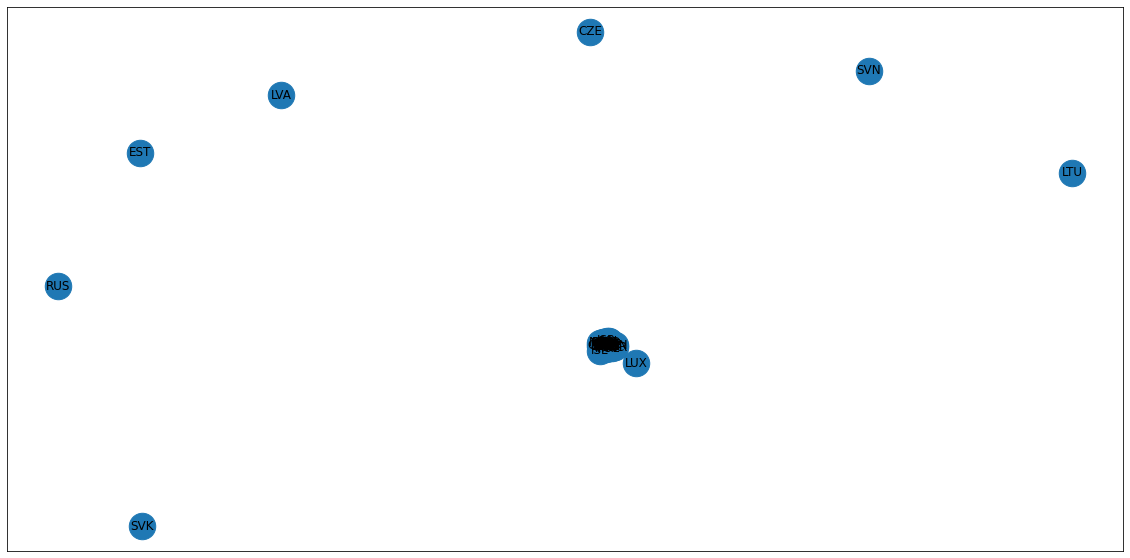

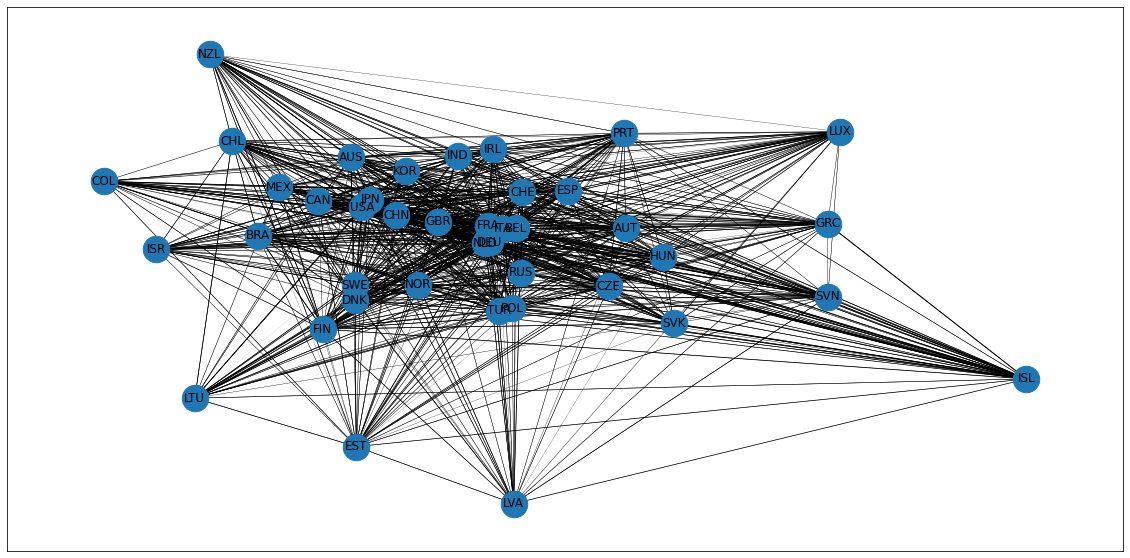

In [5]:
EDGE_WIDTH_MULTIPLIER=-0.1

def plotGraph(g):
    plt.figure(figsize=(20,10))

    # Layout the graph using a spring model
    pos = nx.spring_layout(g, iterations=100, weight="weight")

    # Draw the nodes on the screen
    nx.draw_networkx_nodes(g, pos, node_size=700)

    # Add labels to the nodes
    nx.draw_networkx_labels(g, pos)

    # Create an array with edge widths
    edgewidth = []
    for u, v, d in g.edges(data=True):
        if(d['weight'])>0:
            weight = math.log(d['weight'])*EDGE_WIDTH_MULTIPLIER
            edgewidth.append(weight)

    # Use the edgewidth array to draw the edges
    _ = nx.draw_networkx_edges(g, pos, width=edgewidth, )
    
plotGraph(g1980)
plotGraph(g2013)

Similarities: Althoug it is not appreciable in the image, in the first graph there is a big connected component in both graphs.

Diferences: The 2013 graph has more edges and in general of a higher weight. It makes sense with the process of expansion and globalization we had during these years.

# 3. Compute total imports and exports


Compute total imports and total exports per country. Store total imports in a dictionary indexed by country name `total_imports` and total exports in `total_exports`.


In [6]:
def totals(g):
    exports= dict([(element,0) for element in COUNTRIES])
    imports= dict([(element,0) for element in COUNTRIES])
    
    for u, v, d in g.edges(data=True):
        w = d['weight']
        exports[u]+=w
        imports[v]+=w
        
        
    return ([exports,imports])    
        
    
totals1980=totals(g1980)  
exports1980=totals1980[0]
imports1980=totals1980[1]

totals2013=totals(g2013)  
exports2013=totals2013[0]
imports2013=totals2013[1]


Print these dictionaries, using the code provided below. What we are doing is converting the data to a [Pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) and use Panda's printing functions.


In [7]:
sorted_countries = sorted(COUNTRIES)

flowsData = {
    'exp1980': [exports1980[c] for c in sorted_countries],
    'imp1980': [imports1980[c] for c in sorted_countries],
    'exp2013': [exports2013[c] for c in sorted_countries], 
    'imp2013': [imports2013[c] for c in sorted_countries],
}

flowsDF = pd.DataFrame(flowsData, index=sorted_countries)
flowsDF

,exp1980,imp1980,exp2013,imp2013
AUS,1321,1249,16915,13343
AUT,1169,1666,12194,13356
BEL,4331,4876,31018,31902
BRA,1078,873,8069,9519
CAN,4917,4055,36005,35641
CHE,2248,2972,16461,16644
CHL,259,246,5475,5211
CHN,715,1100,100868,49216
COL,294,291,2859,2787
CZE,0,0,12120,11222


# 4. Compute hubs and authorities

Implement the iterative algorithm seen in class for hubs and authorities. Instead of vectors, we will use two dictionaries having country names as keys. Dictionary `h` should contain the hub scores, while dictionary `a` should contain the authority scores.

Start from normalized hub scores: the hub score should be *1/N* for each country, where *N* is the number of countries.

Then, perform 50 iterations of the following:

1. Compute authority scores from hub scores; do not normalize the edge weights
1. Normalize the authority scores.
1. Compute hub scores from authority scores; do not normalize the edge weights
1. Normalize the hub scores.

Create two functions: `normalize(d)` that sums the values of a dictionary and then divides each one by the sum, returning the resulting dictionary, and `hubs_authorities(g, total_exports, total_imports)` that computes hubs and authorities.

In [8]:
def normalize(d):
    sum=0
    for index in d:#compute the sum
        sum+=d[index]
    for index in d:#normalize the dictionary
        d[index]=d[index]/sum
    
    return d

def hubs_authorities(g,exports,imports):
    h= dict([(element,1/len(COUNTRIES)) for element in g.nodes])#create dicctionaries for the hubs and authorities
    a= dict([(element,0) for element in g.nodes])
    for iteration in range(50):#iterate 50 times
        for u, v, d in g.edges(data=True):
            a[v]+=h[u]*(d['weight'])#compute the authority scores
        a=normalize(a)#normalize them
        
        for u, v, d in g.edges(data=True):#hubs
            h[u]+=a[v]*(d['weight'])#compute the hub scores    
        h=normalize(h)#normalize them
    return(h,a) 
    

In [9]:
print("Computing for 1980")
(h1980,a1980) = hubs_authorities(g1980, exports1980, imports1980)

print("Computing for 2013")
(h2013,a2013) = hubs_authorities(g2013, exports2013, imports2013)

Computing for 1980
Computing for 2013


In [10]:
# Add these columns to your data frame
flowsDF['h1980'] = pd.Series(h1980)
flowsDF['a1980'] = pd.Series(a1980)
flowsDF['h2013'] = pd.Series(h2013)
flowsDF['a2013'] = pd.Series(a2013)

flowsDF

,exp1980,imp1980,exp2013,imp2013,h1980,a1980,h2013,a2013
AUS,1321,1249,16915,13343,1.352959e-02,0.015919,0.013540,0.022372
AUT,1169,1666,12194,13356,1.395691e-02,0.022775,0.009603,0.014329
BEL,4331,4876,31018,31902,5.762767e-02,0.065154,0.023286,0.027016
BRA,1078,873,8069,9519,1.441417e-02,0.013274,0.013248,0.009134
CAN,4917,4055,36005,35641,8.226636e-02,0.071007,0.124204,0.048749
CHE,2248,2972,16461,16644,2.713020e-02,0.037892,0.017870,0.017528
CHL,259,246,5475,5211,3.438658e-03,0.003726,0.006076,0.008423
CHN,715,1100,100868,49216,8.072476e-03,0.015032,0.197172,0.046240
COL,294,291,2859,2787,4.160900e-03,0.004477,0.008180,0.003174
CZE,0,0,12120,11222,3.760872e-191,0.000000,0.007312,0.012297


Print the top 5 countries by exports, imports, hubs, and authorities in 2013 (that is, print 4 lists).

You can use the following command: `display(flowsDF.sort_values(by=colname, ascending=False).head(5))`


display(flowsDF.sort_values(by="exp2013", ascending=False).head(5))
display(flowsDF.sort_values(by="imp2013", ascending=False).head(5))
display(flowsDF.sort_values(by="h2013", ascending=False).head(5))
display(flowsDF.sort_values(by="a2013", ascending=False).head(5))

We can see a clearly correlation between hubs-exports and authorities-imports. By definition, a hubs is a node which points to many authorities, and authority is a node which receive and score of many hubs: roughly "an important node is a node which is pointed by other important nodes". This is not the same as the quantity of imports or exports, but it has some relation since the chances of being an important hub/authority are higher if the number of exports/imports of a country are higher.
Therefore, we come observe some countries like China which are in the top 5 of importers, but not in the top 5 of authorities, they import a lot, but important countries are not exportingto them.

# 5. Comparison of hub/export, authority/import scores

Now, we will compare the hub score of a country against its exports, and the authority scores of a country against its imports.

We can do this visually by plotting both in log-log scale. You can use the following code snippet, which assumes we are plotting dictionary *a* against dictionary *b*:

```python
# Create log-log plot
plt.figure(figsize=(20,10))
plt.loglog()

# Add a diagonal line
plt.plot([min(a.values()),max(a.values())], [min(b.values()),max(b.values())], '-.', lw=2)

# Do the scatter plot with texts
for country in set(a.keys()).intersection(set(b.keys())):
    plt.text(a[country], b[country], country)
```

Remember to add a title, as well as labels to the x axis and y axis before delivering your plots, and to use a function to draw your plots: do not duplicate code.


In [11]:
#FUNCTION TO CREATE SCATTER PLOT
for i in h1980:#there were some really low values which I treated them as 0
    if(h1980[i]<0.0009):
        h1980[i]=0
for i in a1980:
    if(a1980[i]<0.0009):
        a1980[i]=0

def plot(a,b):
    # Create log-log plot
    plt.figure(figsize=(20,10))
    #plt.loglog() My code crashed if i let this part

    # Add a diagonal line
    plt.plot([min(a.values()),max(a.values())], [min(b.values()),max(b.values())], '-.', lw=2)

    # Do the scatter plot with texts
    for country in set(a.keys()).intersection(set(b.keys())):
        plt.text(a[country], b[country], country)


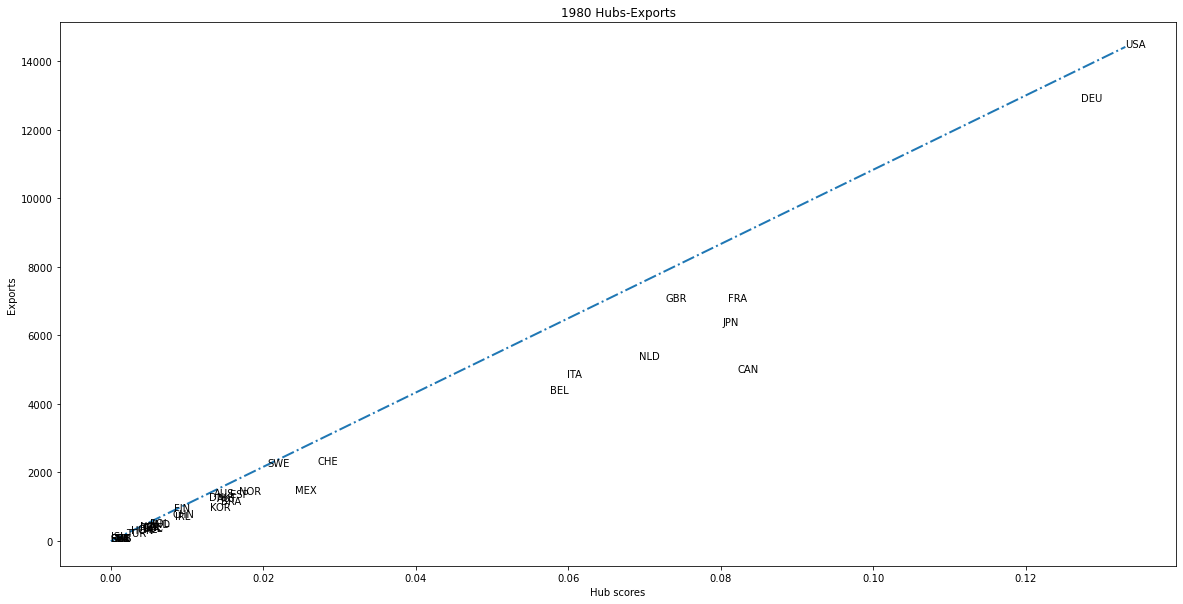

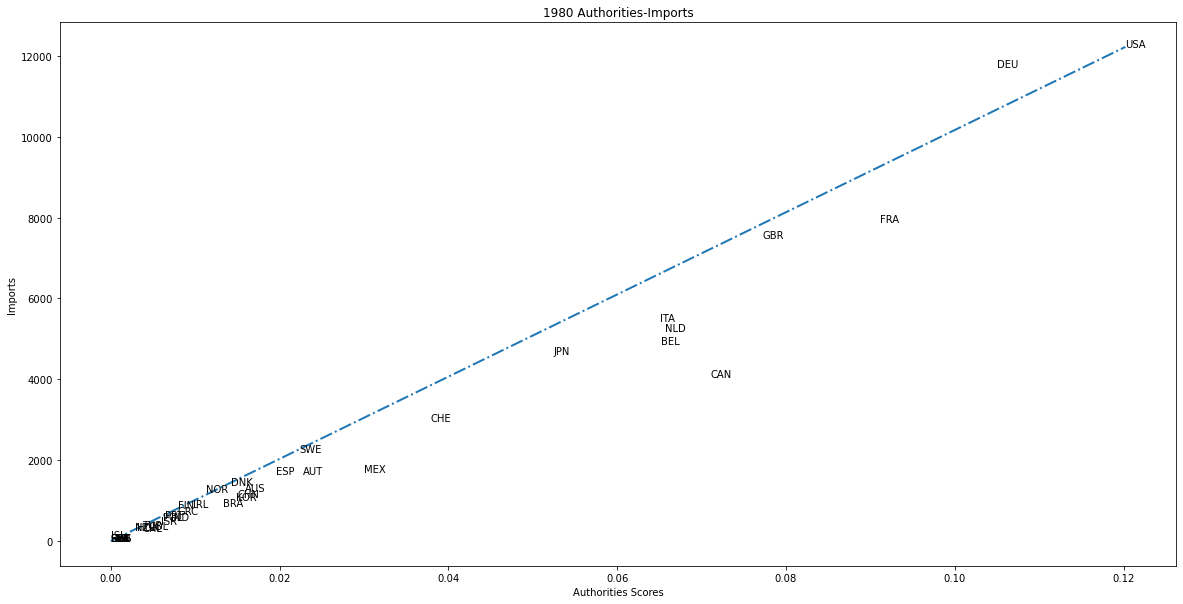

In [12]:
#SCATTERPLOTS 1980: ONE COMPARING HUB SCORES AGAINST EXPORTS AND OTHER COMPARING AUTHORITY SCORES AGAINST IMPORTS
plot(h1980,exports1980)
plt.title("1980 Hubs-Exports")
plt.xlabel("Hub scores")
plt.ylabel("Exports")
plt.show()

plot(a1980,imports1980)
plt.title("1980 Authorities-Imports")
plt.xlabel("Authorities Scores")
plt.ylabel("Imports")
plt.show()

We observe that the hubs and exports have a very high correlation: an increase in the hub score means an increase of similar size in the exports.
For the authorities score we can observe the same relation: an increase in the authorities score means an increase of similar size in the imports

Most countries have a low value of imports/exports and authority/hub. Then there is a little group of "middle value" countries, and finally we have three countries (USA, DEU and FRA) which are the ones getting the most part of the scores and doing more imports/exports thant any other country.

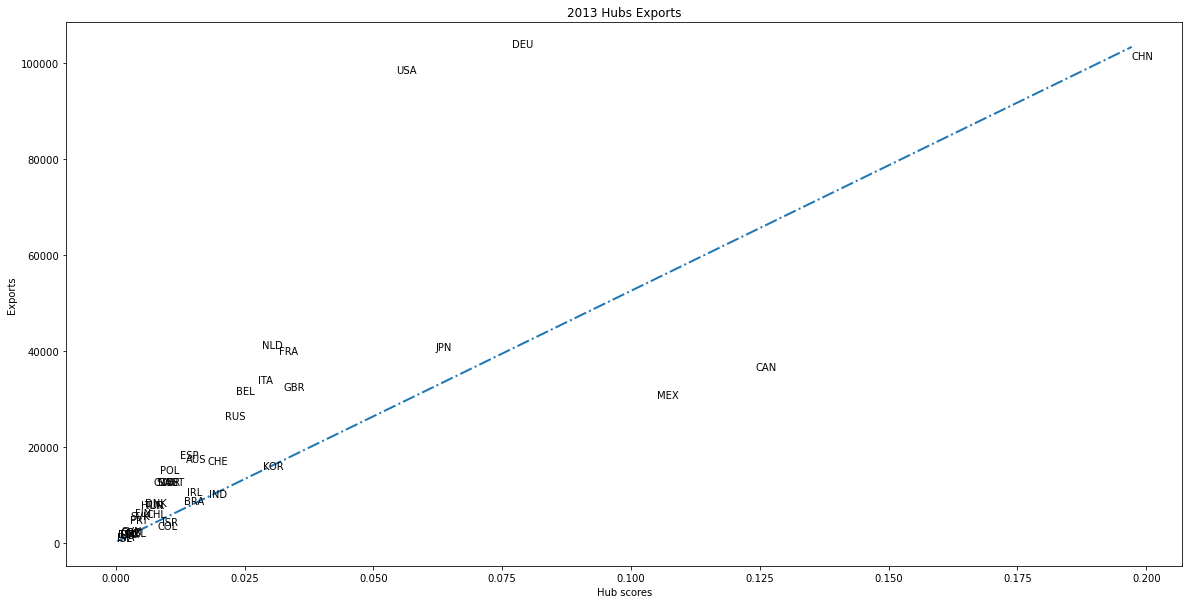

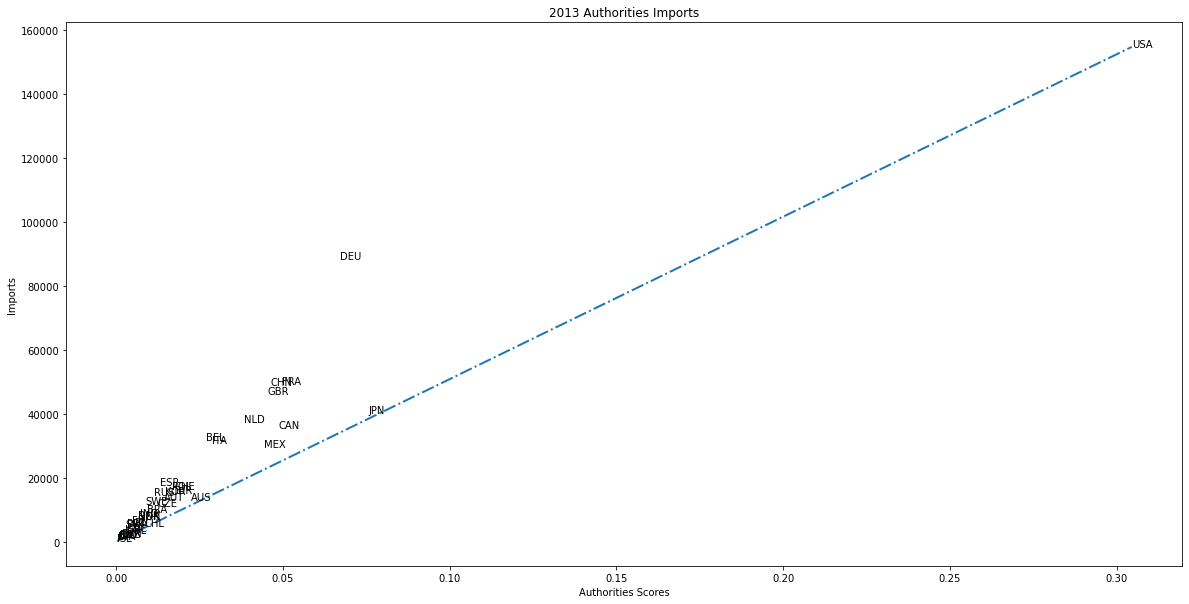

In [13]:
#SCATTERPLOTS 2013: ONE COMPARING HUB SCORES AGAINST EXPORTS AND OTHER COMPARING AUTHORITY SCORES AGAINST IMPORTS
plot(h2013,exports2013)
plt.title("2013 Hubs Exports")
plt.xlabel("Hub scores")
plt.ylabel("Exports")
plt.show()

plot(a2013,imports2013)
plt.title("2013 Authorities Imports")
plt.xlabel("Authorities Scores")
plt.ylabel("Imports")
plt.show()

In 2013 we can see a different situation. Now the correlation is not as high as before: now it is much more common to find countries which differ a lot of the blue line of the graph.
The nominal value of exports/imports has increased a lot, and now countries such as DEU or USA, export much more than before but they have a lower hub score than the one we should predict in 1980: they are not exporting to so important countries as in 1980. Now the most important country is China by a huge difference.
Refering to the authority scores, USA remains at the top but the rest of "high-middle" countries we had in 1980 have diminished their authoirity values and now all these countries are in the group of countries with low authority score.(This effect can also be obsreved in the hub scores of 2013)

OVERALL CONCLUSIONS

In conclusion, we have find that although it's correlation has decreased over the time, the authority/hub scores have a positive correlation with imports/exports. A part from that, we can confirm that the HITS algorithm aims to rank the countries for importance rether than for quantity, since from 1980 to 2013 all the countries increased the values of imports/exports in a huge quantity but the algorithm managed to keep distributing it's importance. 